#### (Home credit competition 중심으로)
## 2.4 데이터 정제 - 상관계수

---
### 소스 및 데이터는 아래 kaggle을 참조하였습니다. 
* 캐글 주소 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* 해당 커널의 한글 번역은 파파고와 구글을 활용하였습니다.
___

In [1]:
# 라이브러리 

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
# 데이터 셋
app_train = pd.read_csv('d:/Projects/Cp/input/application_train.csv')
app_test = pd.read_csv('d:/Projects/Cp/input/application_test.csv')

In [3]:
#  레이블 인코딩 
le = LabelEncoder()
le_count = 0

for col in app_train:    
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2: 
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col]  = le.transform(app_test [col])            
            le_count += 1

In [4]:
# 원 핫 인코딩
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [5]:
# 원 핫 인코딩 후 훈련/테스트 용 데이터 열(컬럼) 일치화

# TARGET(대출금 상환여부)열 따로 보관
train_labels = app_train['TARGET']

# 열(컬럼)기준 데이터 정렬하여 서로 없는 열(컬럼) 삭제
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# 학습용 데이터에 TARGET(대출금 상환여부)열 추가
app_train['TARGET'] = train_labels

In [6]:
# 취업일(DAYS_EMPLOYED) 이상치 데이터 처리

# 훈련용 셋
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 테스트용 셋
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [7]:
#편의를 위해 DAYS_BIRTH의 절대값을 취하여 양수를 만듭니다
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [8]:
# 연령대 정보를 다른 데이터프레임에 저장하고 년으로 환산
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 나이 구간 설정
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

#### 외부 출처 자료
* 대출상환여부(target)와 가장 강한 음의 상관 관계를 갖는 3개 변수는 EXT_SOURCE_1, EXT_SOURCE_2 및 EXT_SOURCE_3입니다. 
* 문서에 따르면 이러한 특성은 "정규화된 데이터"를 나타냅니다. 
* 이게 정확히 무슨 뜻인지는 모르겠지만, 수많은 데이터 출처를 이용하여 쌓은 신용등급일 수도 있습니다.
* 이 변수들을 살펴봅시다.

#### EXT_SOURCE들과 대출상환여부(target)의  상관 관계

In [9]:
# EXT_SOURCE_1, 2, 3 변수 추출 및 상관관계
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


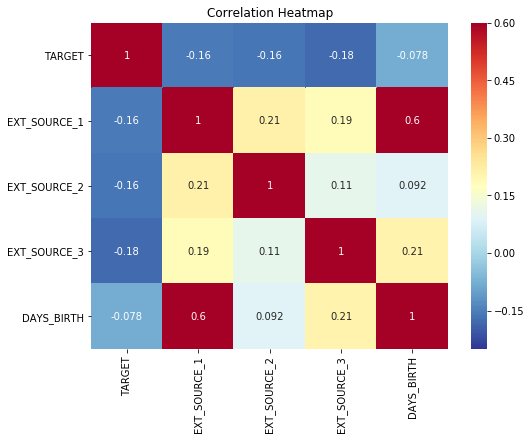

In [10]:
plt.figure(figsize = (8, 6))

# 상관관계 지도
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

* 3개의 EXT_SOURCE 피쳐 모두 대출상환여부(Target)와 음의 상관관계를 가짐니다.
* 음의 상관관계는 EXT_SOURCE의 값이 증가하면 대출신청자는 대출금을 상환 할 가능성이 높다는 것을 나타냅니다. 
* target - 0 : 상환, 1 : 미상환
* DAYS_BIRTH(생일)가 EXT_SOURCE_1과 양의 상관 관계가 있다는 것을 알 수 있습니다. 이는이 점수의 요소 중 하나가 고객의 연령 일 수 있음을 나타냅니다.
* 다음으로 우리는 각 EXT_SOURCE 피쳐별 상관관계 값으로 채색 된 분포를 볼 수 있습니다. 그러면 이 변수가 대상에 미치는 영향을 시각화 할 수 있습니다.

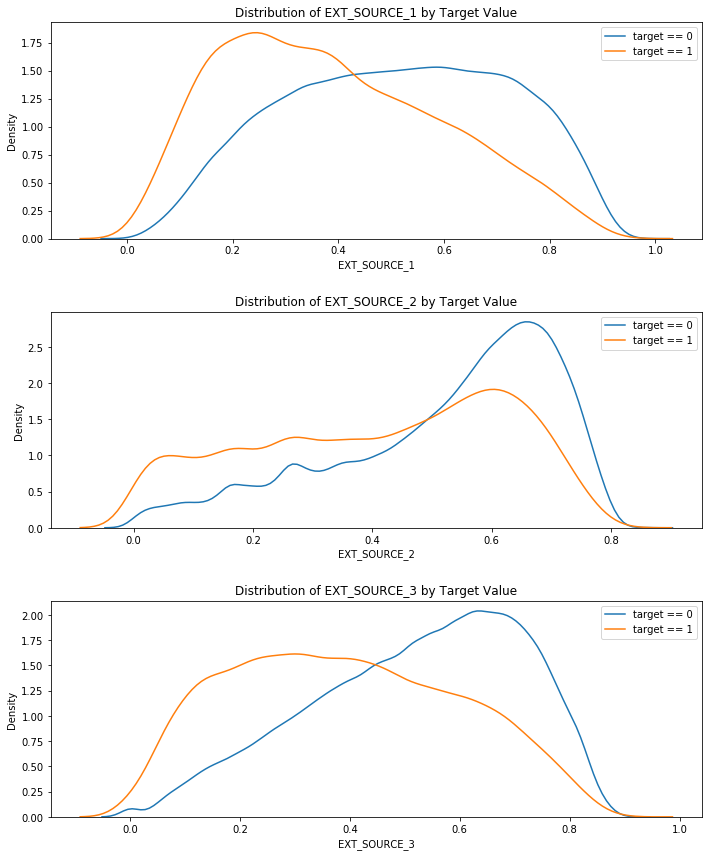

In [11]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    
    # 대출상환
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    
    # 대출 미상환
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

* 대출상환여부(TARGET)

> 1 : 대출 미상환

> 0 : 대출 상환


* EXT_SOURCE 중 EXT_SOURCE_3이 대출상환여부(target)와 상간계수 값이 가장 큽니다.(- 0.18)
* 이 피처는 대출금 신청자가 대출금을 상환할 가능성과 어느 정도 관련이 있다는 것을 분명히 알 수 있습니다.
* 이 관계는 그다지 강하지 않고 실제로 그것들은 모두 매우 약하다고 보여집니다.
* 그러나 이 변수들은 대출 신청자가 제때 대출을 갚을지 여부를 예측하는 기계 학습 모델에 여전히 유용할 것입니다.
___

#### 쌍 그림(Pairs Plot)
* 마지막 데이터 탐색으로 EXT_SOURCE 변수와 DAYS_BIRTH 변수의 쌍 그림을 그릴 수 있습니다. 
* Pairs Plot은 여러 쌍의 변수와 단일 변수의 분포 사이의 관계를 확인할 수 있기 때문에 훌륭한 탐색 도구입니다. 
* 여기서는 Seaborn 시각화 라이브러리와 PairGrid 함수를 사용하여 위쪽 삼각형의 산점도, 대각선의 히스토그램, 아래쪽 삼각형의 2D 커널 밀도 그림 및 상관 계수가 포함된 쌍 그림을 작성합니다.
___
* (아래 코드를 이해하지 못해도 괜찮습니다.)

C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\anaconda\envs\keras\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwarg

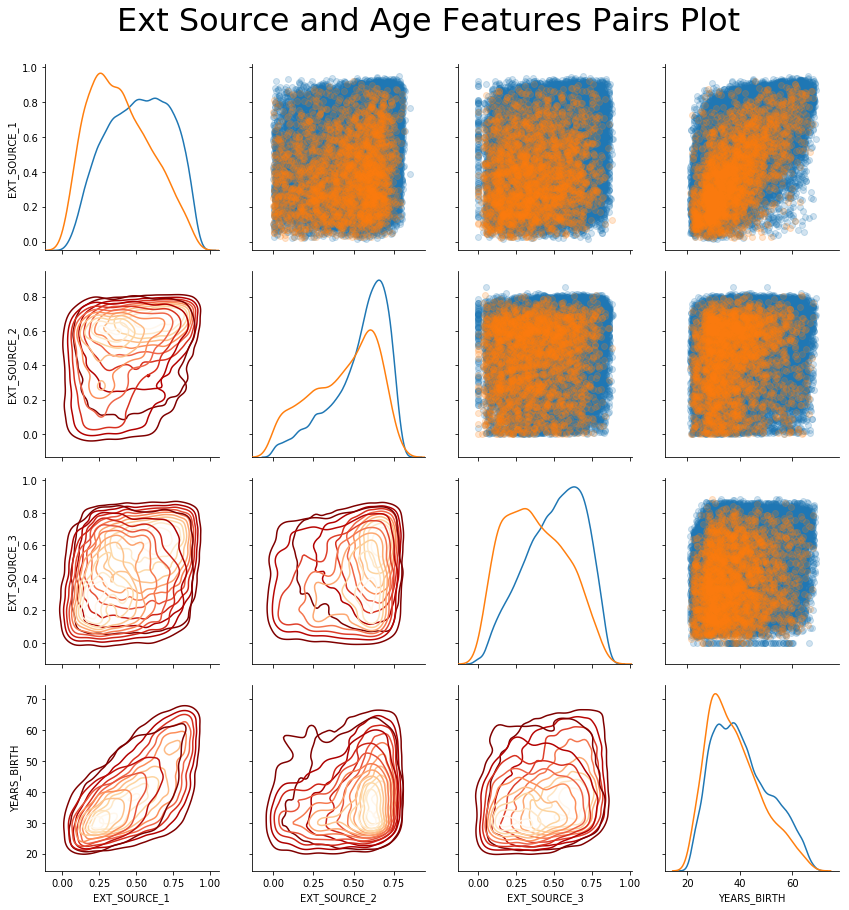

In [12]:
# plot_data 데이터프레임에 그래프에 사용할 DAYS_BIRTH(생일) 데이터 복사
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# lot_data 데이터프레임에 고객 나이 추가
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# 1 ~ 100000행 중 결측값 있는 행제거 및 선택 (데이터가 많아 일부만 사용)
plot_data = plot_data.dropna().loc[:100000, :]

# 두 열 사이의 상관 계수를 계산하는 함수
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# pairgrid 객체 생성
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# 위쪽 삼각형은 산점도 그래프
grid.map_upper(plt.scatter, alpha = 0.2)

# 대각선은 막대 그래프
grid.map_diag(sns.kdeplot)

# 아래쪽 삼각형은 밀도 그래프
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);


* 이 그림에서 빨간색은 대출금 미상환, 파란색은 대출금 상환을 나타냅니다. 
* 우리는 데이터 내에서 서로 다른 관계를 볼 수 있습니다. 
* EXT_SOURCE_1과 DAYS_BIRTH(또는 이와 동등한 YEARS_BIRTH) 사이에는 중간 정도의 양의 선형 관계가 있는 것으로 나타납니다.
* 이 피처가 대출 신청자의 경과 시간을 고려할 수 있음을 나타냅니다.